In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score, accuracy_score
import warnings
from sklearn.metrics import fbeta_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import roc_curve, auc
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns',None)

In [4]:
df=pd.read_csv('practice-datasets/train_dataset_final1.csv')
df.sample(5)

,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,Bill_amt1,Bill_amt2,Bill_amt3,Bill_amt4,Bill_amt5,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,next_month_default
9285,14302,1,1,2,40000,43.0,0,0,0,0,0,0,36415.33,37408.43,30017.90,30425.27,22866.80,12899.52,1939.07,1398.79,806.12,861.92,258.13,0.09,28339.33,0.03,0
7804,12821,2,1,1,30000,25.0,0,0,0,0,0,0,19782.84,20958.42,22268.39,22601.84,23085.27,23645.96,1500.21,1668.09,999.93,999.76,943.98,761.77,22057.17,0.05,0
22997,28014,2,1,2,60000,25.0,0,0,0,0,0,0,34991.23,36105.82,37220.05,38253.57,39369.49,36591.11,1999.94,2000.05,1999.94,1999.71,1399.95,1400.17,37088.67,0.05,1
21241,26258,2,0,2,20000,25.0,0,0,0,0,0,0,13896.43,12906.00,13983.72,10982.96,5399.81,0.00,2000.24,2499.71,1999.83,0.12,0.00,0.20,9528.00,0.11,1
16928,21945,2,0,1,280000,31.0,0,0,0,0,0,0,168382.83,175645.34,180649.67,182671.79,168399.33,167983.06,10000.11,8000.21,6370.90,6216.96,5947.20,6288.26,173955.33,0.04,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25247 entries, 0 to 25246
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer_ID         25247 non-null  int64  
 1   marriage            25247 non-null  int64  
 2   sex                 25247 non-null  int64  
 3   education           25247 non-null  int64  
 4   LIMIT_BAL           25247 non-null  int64  
 5   age                 25121 non-null  float64
 6   pay_0               25247 non-null  int64  
 7   pay_2               25247 non-null  int64  
 8   pay_3               25247 non-null  int64  
 9   pay_4               25247 non-null  int64  
 10  pay_5               25247 non-null  int64  
 11  pay_6               25247 non-null  int64  
 12  Bill_amt1           25247 non-null  float64
 13  Bill_amt2           25247 non-null  float64
 14  Bill_amt3           25247 non-null  float64
 15  Bill_amt4           25247 non-null  float64
 16  Bill

In [6]:
# Replace unexpected education values with '4' (Others)
# Replace unexpected marriage values with '3' (Others)
df['education'] = df['education'].replace({0: 4, 5: 4, 6: 4})
df['marriage'] = df['marriage'].replace({0: 3})

In [7]:
df.duplicated().sum() # no duplicate values in the dataset

0

In [8]:
df.rename(columns={'pay_0':'pay_1'}, inplace=True) # renaming pay_0 to pay_1

In [9]:
df.drop('Customer_ID',axis=1,inplace=True) #Customer_ID shows no correlation with anything. So we can drop it

In [10]:
df.shape

(25247, 26)

In [11]:
# Customers who overpaid
overpaid_df = df[df['AVG_Bill_amt'] < 0]

# Count how many of them defaulted
num_defaulted = overpaid_df['next_month_default'].sum()
total_overpaid = len(overpaid_df)

print(f"Total overpaid customers: {total_overpaid}")
print(f"Number of overpaid customers who defaulted: {num_defaulted}")
print(f"Default rate among overpaid customers: {100 * num_defaulted / total_overpaid:.2f}%")

Total overpaid customers: 170
Number of overpaid customers who defaulted: 33
Default rate among overpaid customers: 19.41%


In [12]:
# Drop users with negative average billing amount
df = df[df['AVG_Bill_amt'] >= 0].copy()
df = df[df['PAY_TO_BILL_ratio'] >= 0].copy()

In [13]:
# imputing null value of age column
df['age'] = df.groupby('marriage')['age'].transform(lambda x: x.fillna(x.median()))

In [14]:
df.isnull().sum()

marriage              0
sex                   0
education             0
LIMIT_BAL             0
age                   0
pay_1                 0
pay_2                 0
pay_3                 0
pay_4                 0
pay_5                 0
pay_6                 0
Bill_amt1             0
Bill_amt2             0
Bill_amt3             0
Bill_amt4             0
Bill_amt5             0
Bill_amt6             0
pay_amt1              0
pay_amt2              0
pay_amt3              0
pay_amt4              0
pay_amt5              0
pay_amt6              0
AVG_Bill_amt          0
PAY_TO_BILL_ratio     0
next_month_default    0
dtype: int64

# Exploratory Data Analysis (EDA)

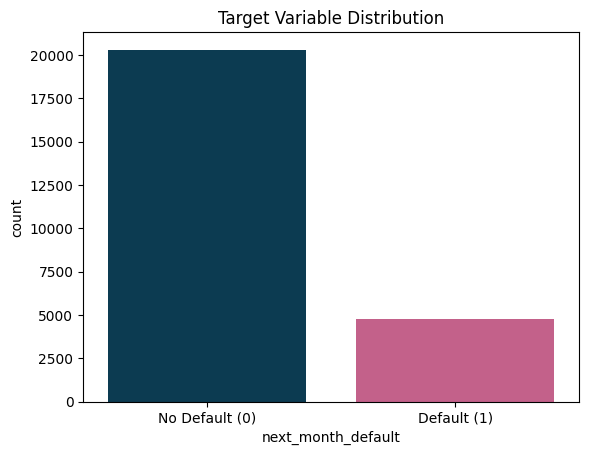

next_month_default
0    80.962635
1    19.037365
Name: proportion, dtype: float64


In [15]:
# Plot class distribution
blue_palette = [
    "#003f5c",  # Dark navy blue
    "#d45087",  # Pinkish-blue
]
sns.set_palette(blue_palette)
sns.countplot(x='next_month_default', data=df)
plt.title("Target Variable Distribution")
plt.xticks([0, 1], ["No Default (0)", "Default (1)"])
plt.show()

# Percentage of each class
print(df['next_month_default'].value_counts(normalize=True) * 100)

**Default Status Distribution:** The first graph clearly shows that a large majority of customers did *not* default in the next month. The number of customers who defaulted is significantly smaller. This indicates an imbalanced dataset with respect to the target variable.

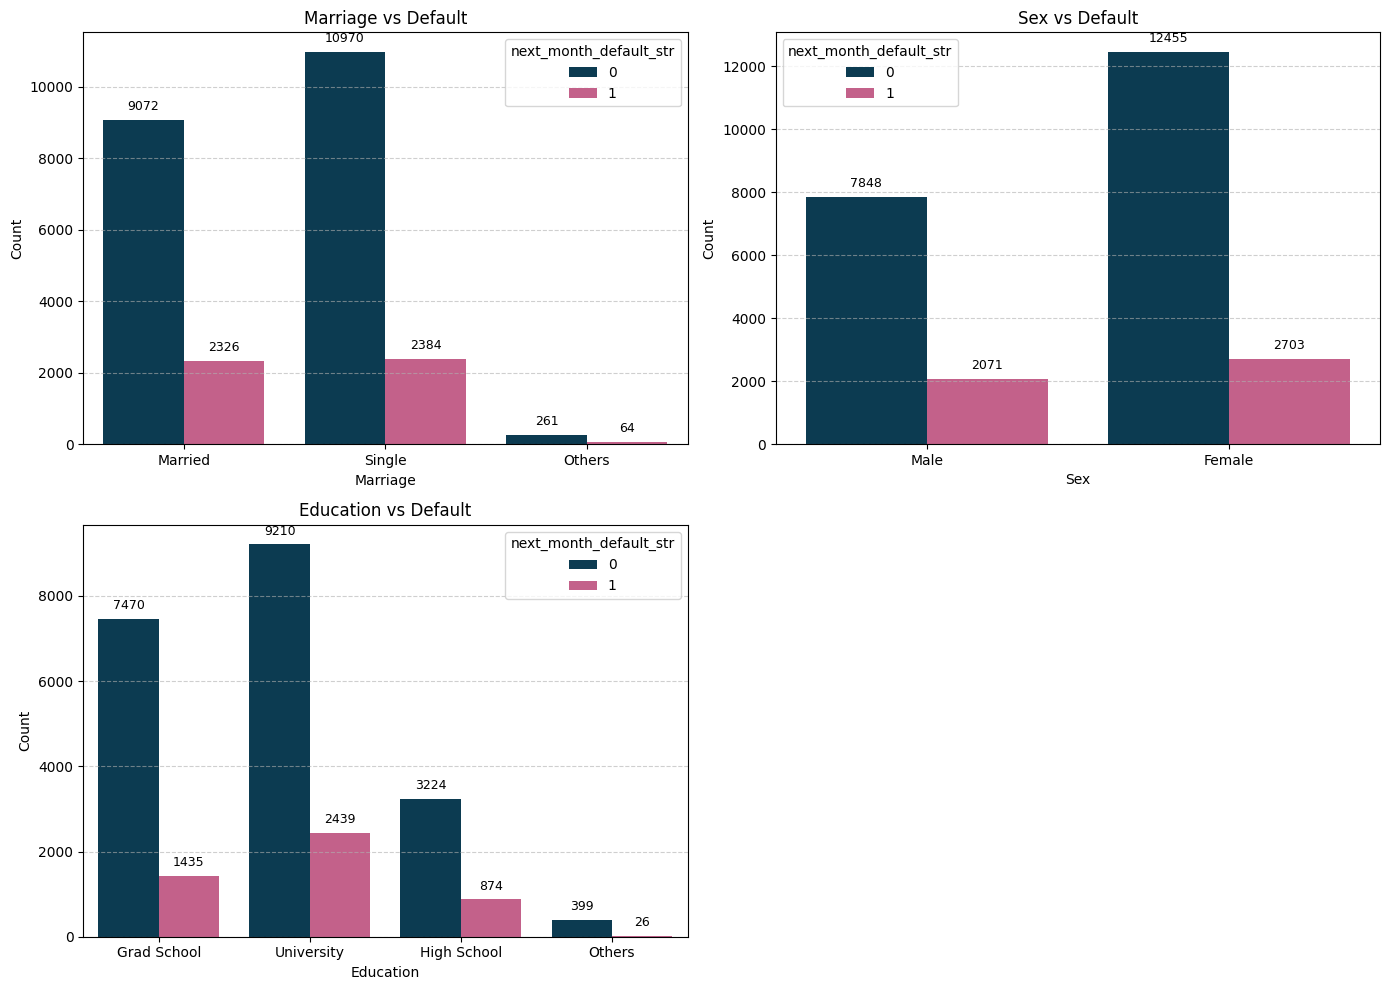

In [16]:
blue_palette = [
    "#003f5c",  # Dark navy blue
    "#d45087",  # Pinkish-blue
]

# Features and labels
plot_features = ['marriage', 'sex', 'education']
titles = ['Marriage vs Default', 'Sex vs Default', 'Education vs Default']
xtick_labels = {
    'sex': ['Male', 'Female'],
    'marriage': ['Married', 'Single', 'Others'],
    'education': ['Grad School', 'University', 'High School', 'Others']
}

# Convert default column to string for hue
df['next_month_default_str'] = df['next_month_default'].astype(str)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # Flatten to 1D for easy indexing

# Plot each feature
for i, (col, title) in enumerate(zip(plot_features, titles)):
    ax = axes[i]
    sns.countplot(data=df, x=col, hue='next_month_default_str', palette=blue_palette, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(col.capitalize())
    ax.set_ylabel("Count")
    ax.set_xticklabels(xtick_labels[col])
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    # Annotate bars
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{int(height)}',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom',
                        fontsize=9, color='black', xytext=(0, 5),
                        textcoords='offset points')
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

# Drop helper column
df.drop(columns='next_month_default_str', inplace=True)


 **Marriage vs Default:**
The plot indicates that marital status may influence the likelihood of default. Most customers fall into the “married” (1) and “single” (2) categories, and these groups also account for the majority of defaults. Although “others” (3) form a small segment of the population, their default count is proportionally lower. However, to draw definitive conclusions, it would be important to compute the default rate (defaults as a percentage of each marital category), rather than relying on raw counts alone.

 **Sex vs Default:**
From the visualization, it's evident that the dataset contains more female customers than male. While both genders include defaulters and non-defaulters, the visual spread suggests that the proportion of defaulters may be slightly higher among males. This observation should be verified by calculating the default percentage within each gender group.

 **Education vs Default:**
Educational background appears to be linked to default behavior. The majority of customers have education levels 1 (graduate school), 2 (university), or 3 (high school). Among these, levels 1 and 2 contribute more significantly to the default population. In contrast, education level 4 (others/unknown) shows minimal default activity, likely due to its small sample size. While it may seem counterintuitive that higher education correlates with higher defaults, this trend could reflect lifestyle factors or higher credit usage. A deeper look at default rates per education group would help clarify the relationship.

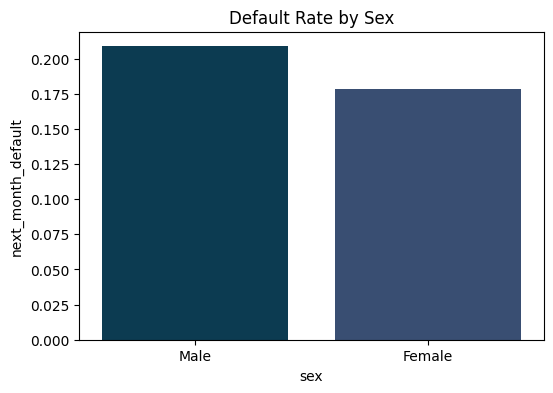

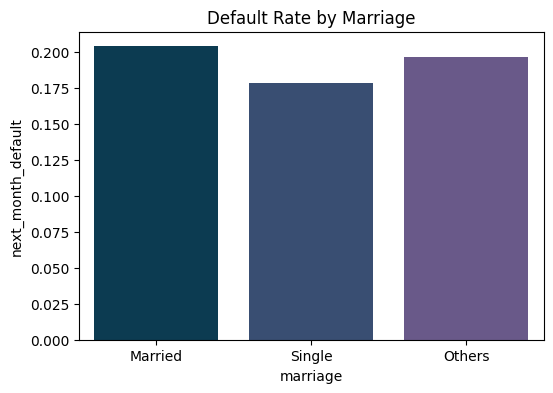

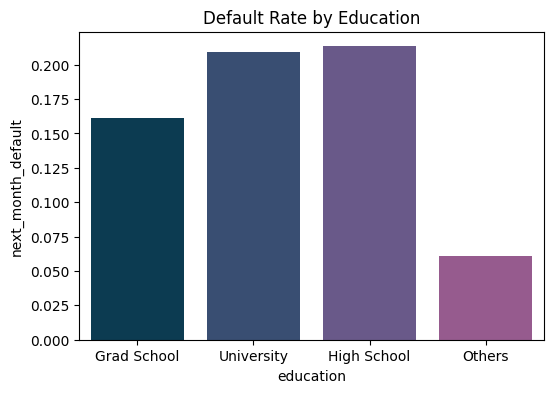

In [17]:
# Sex, Marriage, Education distribution
blue_palette = [
    "#003f5c",  # Dark navy blue
    "#2f4b7c",  # Medium navy
    "#665191",  # Indigo blue
    "#a05195",  # Purple-blue
    "#d45087",  # Pinkish-blue
]
sns.set_palette(blue_palette)
demographics = ['sex', 'marriage', 'education']

for col in demographics:
    plt.figure(figsize=(6,4))
    chart = sns.barplot(x=col, y='next_month_default', data=df, errorbar=None)
    plt.title(f"Default Rate by {col.capitalize()}")
   
    
 # Set human-readable xtick labels
    if col == 'sex':
        chart.set_xticklabels(['Male', 'Female'])
    elif col == 'marriage':
        chart.set_xticklabels(['Married', 'Single', 'Others'])
    elif col == 'education':
        chart.set_xticklabels(['Grad School', 'University', 'High School', 'Others'])
    plt.show()

Insights from these graphs is that
1) Men are more likely to default than feamles
2) Married people are more likely to default
3) High school and university people are more likely to default

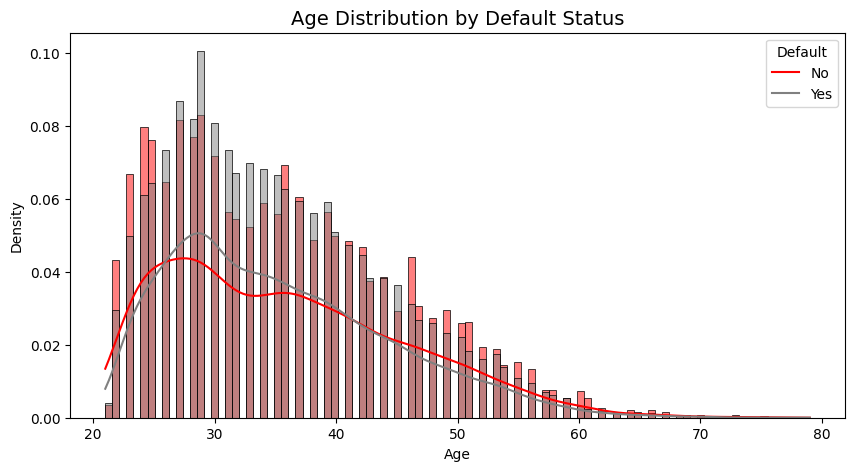

In [18]:
palette = ['grey', 'red']  # 0 = No Default (grey), 1 = Default (red)
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='age', hue='next_month_default',palette = palette, kde=True, bins=100,  stat="density", common_norm=False)
plt.title("Age Distribution by Default Status", fontsize=14)
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend(title='Default', labels=['No', 'Yes'])
plt.show()

As age increases to 30, the probability of default increases. Meanwhile, when clients are over 30, the probability decreases when aging.


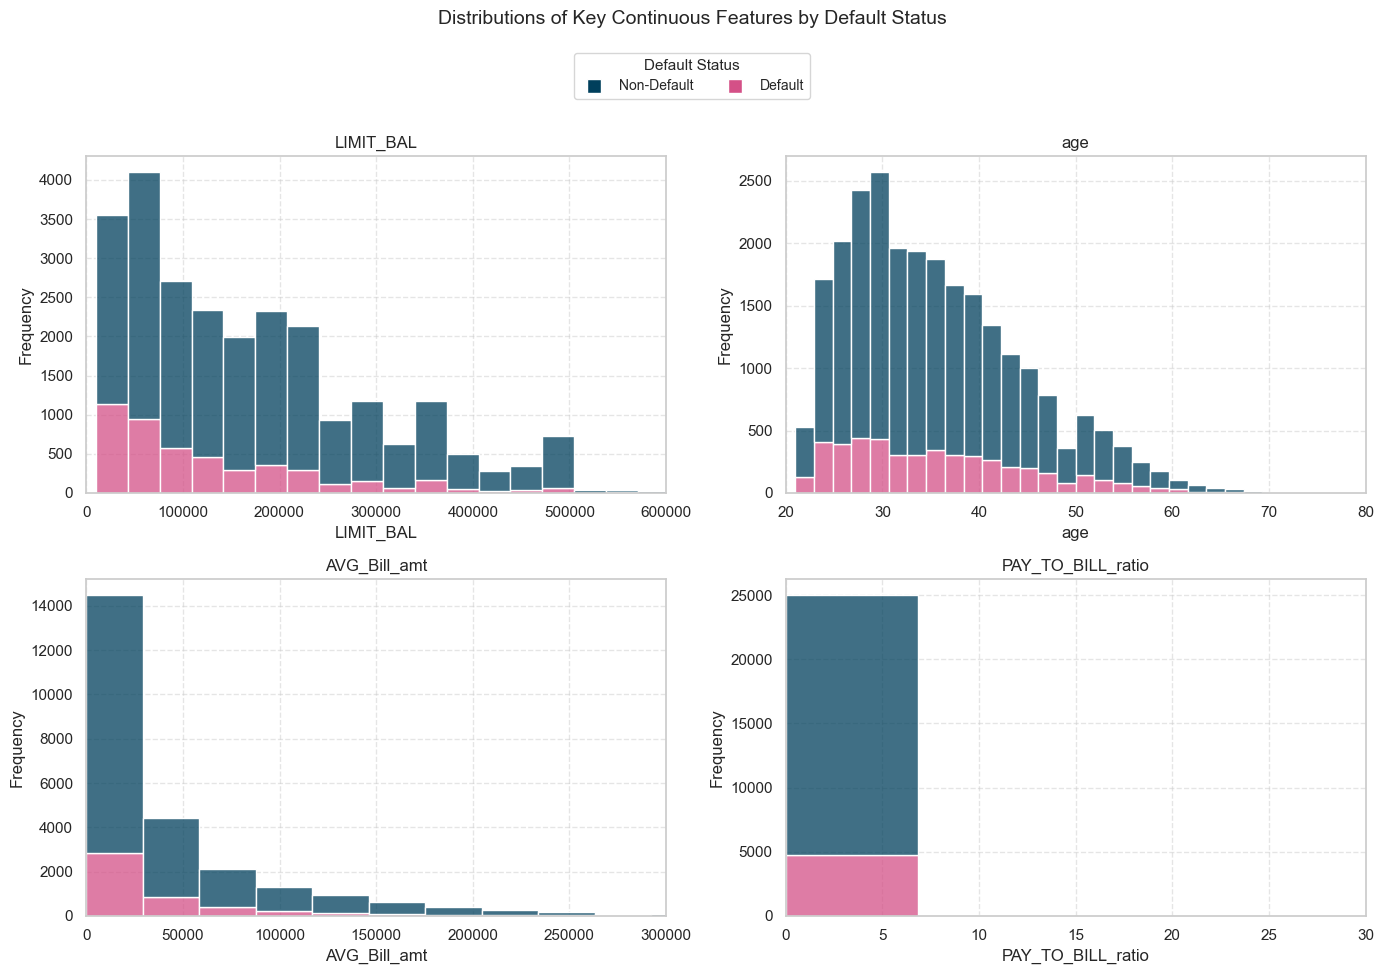

In [19]:
sns.set_theme(style="whitegrid")

blue_palette = [
    "#003f5c",  # Dark navy blue
    "#d45087",  # Pinkish-blue
]

# Continuous features and x-axis clipping
cont_features = ['LIMIT_BAL', 'age', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio']
x_limits = {
    'LIMIT_BAL': (0, 600000),
    'age': (20, 80),
    'AVG_Bill_amt': (0, 300000),
    'PAY_TO_BILL_ratio': (0, 30),
}

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 9))
axes = axes.flatten()

for i, col in enumerate(cont_features):
    sns.histplot(
        data=df,
        x=col,
        hue='next_month_default',
        palette=blue_palette,
        bins=30,
        multiple='stack',
        ax=axes[i],
        legend=False  # Disable local legends
    )
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlim(x_limits[col])
    axes[i].grid(True, linestyle='--', alpha=0.5)

# Create a custom shared legend
custom_handles = [
    plt.Line2D([0], [0], marker='s', color='w', label='Non-Default', markerfacecolor=blue_palette[0], markersize=10),
    plt.Line2D([0], [0], marker='s', color='w', label='Default', markerfacecolor=blue_palette[1], markersize=10)
]
fig.legend(
    handles=custom_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.04),
    ncol=2,
    title='Default Status',
    fontsize=10,
    title_fontsize=11
)

fig.suptitle("Distributions of Key Continuous Features by Default Status", fontsize=14, y=1.08)
plt.tight_layout()
plt.show()

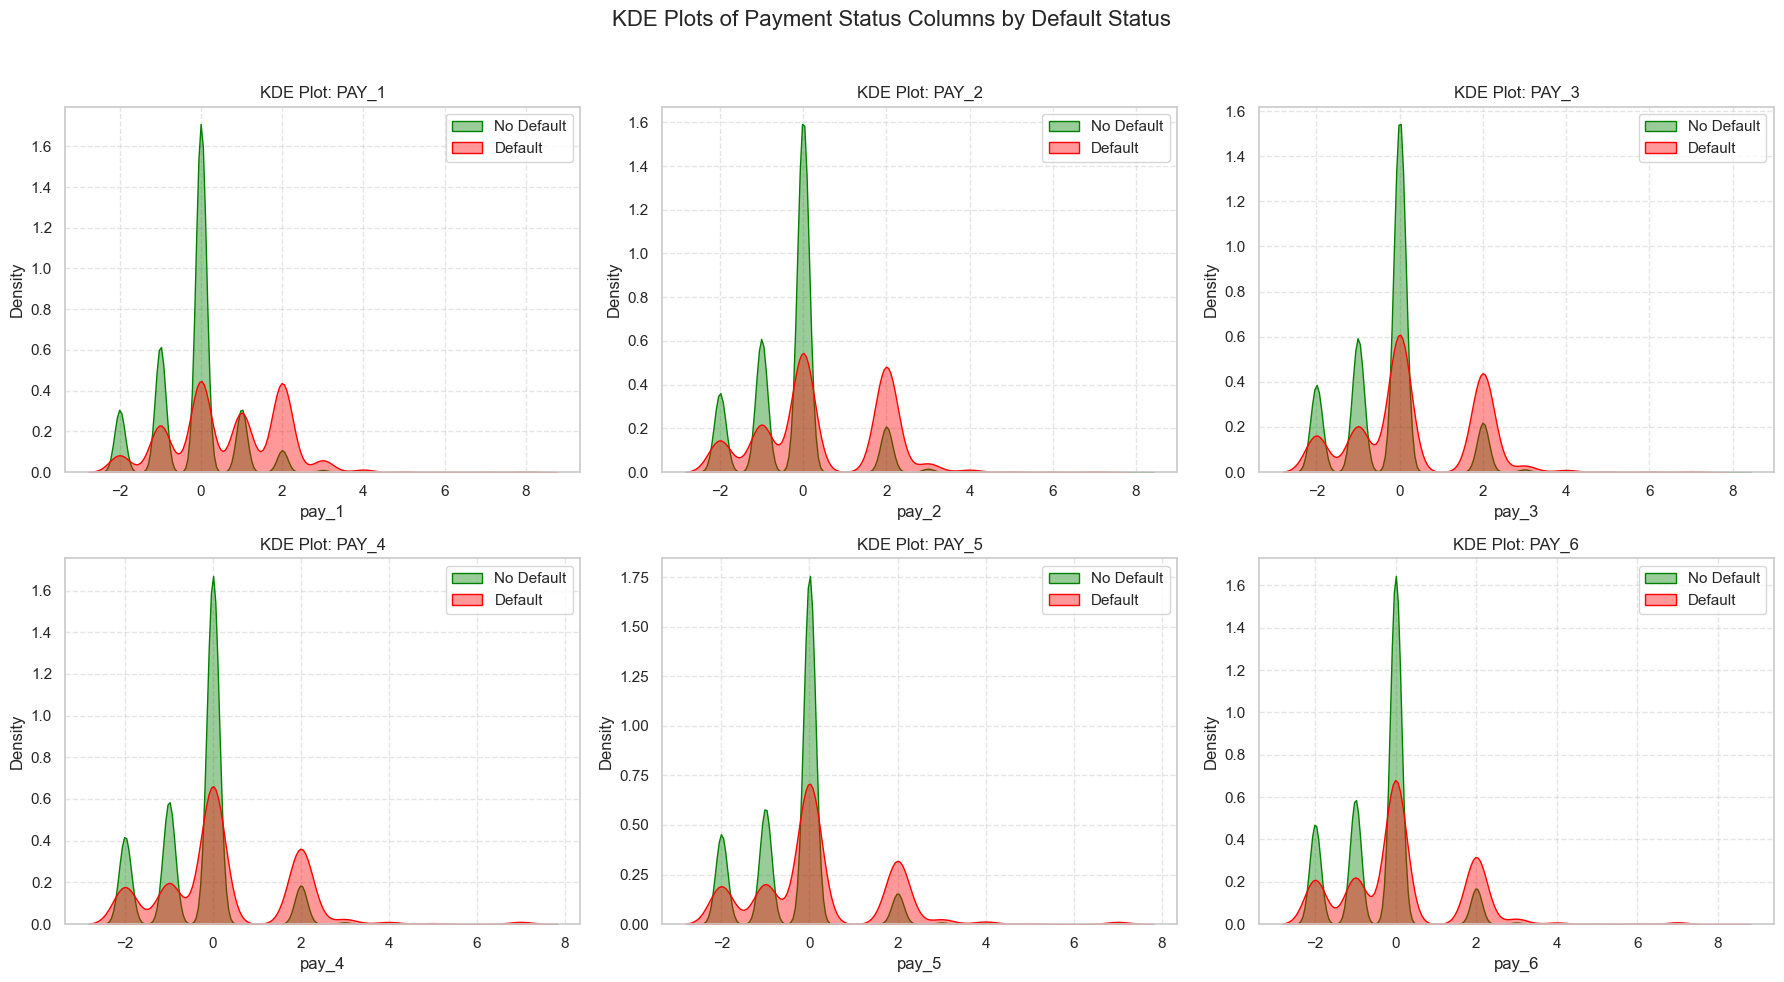

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Payment status columns to plot
pay_cols = ['pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']  # Assuming columns are lowercase as in your cleaned dataset

# Set up a grid for subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Loop through payment columns
for i, col in enumerate(pay_cols):
    ax = axes[i]
    sns.kdeplot(data=df[df['next_month_default'] == 0], x=col, label='No Default', ax=ax, fill=True, alpha=0.4, color='green')
    sns.kdeplot(data=df[df['next_month_default'] == 1], x=col, label='Default', ax=ax, fill=True, alpha=0.4, color='red')
    ax.set_title(f'KDE Plot: {col.upper()}')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

plt.suptitle('KDE Plots of Payment Status Columns by Default Status', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Based on the generated histograms and KDE plots:

1.  **Histograms of Numerical Columns (`LIMIT_BAL`, `age`, `AVG_Bill_amt`, `PAY_TO_BILL_ratio`):**
    *   **`LIMIT_BAL`:** The distribution is skewed to the left, with a large number of accounts having a lower credit limit. There's a long tail towards higher credit limits.
    *   **`age`:** The age distribution appears somewhat normally distributed, with a peak in the younger to middle-aged range.
    *   **`AVG_Bill_amt`:** This distribution is highly skewed to the right, indicating that most customers have relatively low average bill amounts, but there are some customers with very high average bill amounts. There's also a significant peak around zero or slightly negative values, which might represent credits or returns which we have dropped as it doesn't show any different behaviour.
    *   **`PAY_TO_BILL_ratio`:** This distribution is also highly skewed, with a large concentration at 0, likely representing customers who paid the full bill amount. There's a spread of values greater than 0, indicating customers who paid less than the full amount.

2.  **KDE Plots for Payment Status Columns (`PAY_1`, `PAY_2`, `PAY_3`, `PAY_4`, `PAY_5`, `PAY_6`) vs. Default Status:**
    *   These plots compare the distribution of payment status values for customers who defaulted versus those who did not default.
    *   Across all `PAY_X` columns, there is a clear distinction between the distributions for non-defaulters (green) and defaulters (red).
    *   For non-defaulters, the distributions are heavily concentrated at 0 (representing no delay or paying in full/on time). There are smaller peaks at negative values, indicating early payments or credits.
    *   For defaulters, the distributions are shifted towards positive values, indicating delays in payment. The peaks for defaulters are around 1, 2, or higher, signifying one-month, two-month, or greater payment delays.
    *   The `PAY_1`shows the most distinct separation. The red (defaulters) distribution has a significant peak at positive values, while the green (non-defaulters) is concentrated at 0 and negative values. This indicates that the most recent payment status is a very strong predictor of default.
    *   As we look at earlier months (`PAY_2` through `PAY_6`), the separation between the distributions for defaulters and non-defaulters is still present but might be slightly less pronounced than `PAY_1`.
    *   These plots strongly suggest that the payment history features are highly informative for predicting default. Customers with recent payment delays are significantly more likely to default in the next month.
    

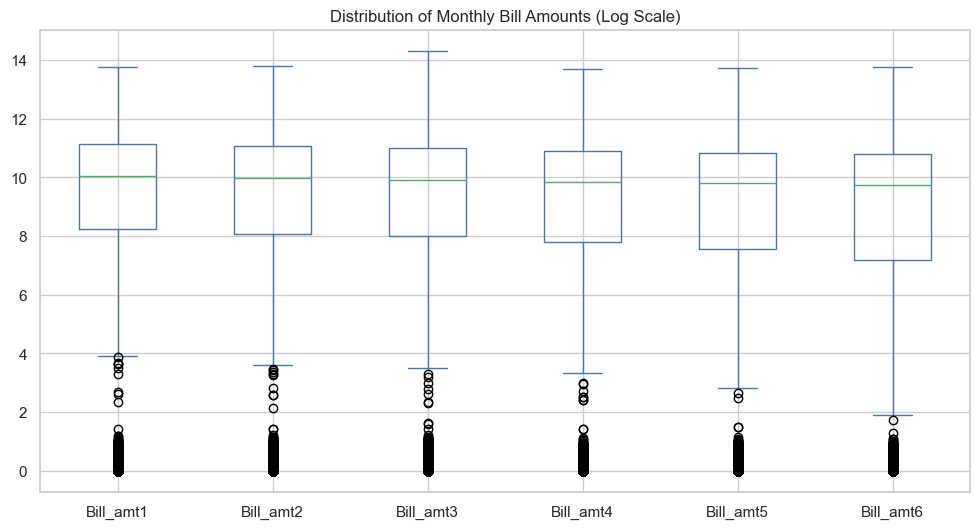

In [21]:
bill_cols = [f'Bill_amt{i}' for i in range(1, 7)]
df[bill_cols] = df[bill_cols].apply(lambda x: np.log1p(x))
df[bill_cols].plot(kind='box', figsize=(12,6), title='Distribution of Monthly Bill Amounts (Log Scale)')
plt.show()

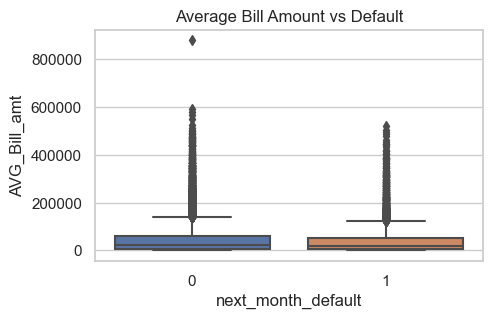

In [22]:
plt.figure(figsize=(5,3))
sns.boxplot(x='next_month_default', y='AVG_Bill_amt', data=df)
plt.title('Average Bill Amount vs Default')
plt.show()

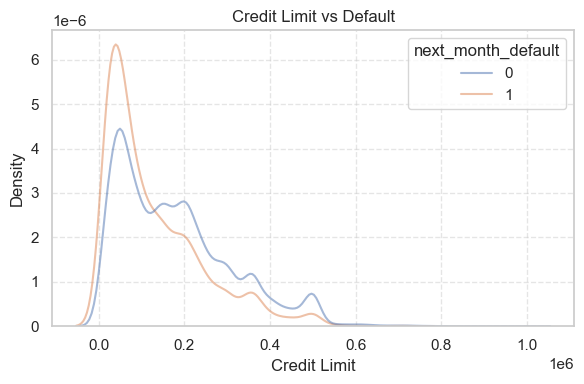

In [23]:
plt.figure(figsize=(6, 4))  # Slightly wider for readability

sns.kdeplot(
    data=df,
    x='LIMIT_BAL',
    hue='next_month_default',
    common_norm=False,
    alpha=0.5
)

plt.title('Credit Limit vs Default', fontsize=12)
plt.xlabel('Credit Limit')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Credit Limit vs Default (Density Plot)**

Skewed Distribution: The credit limit is right-skewed, meaning most customers have lower credit limits.

Default Tendency: Customers with lower credit limits are more likely to default, as indicated by the relatively higher density curve for defaulters (label 1) in that range.

Separation Begins to Blur: As credit limit increases, the distinction between defaulters and non-defaulters diminishes, indicating credit limit alone is not a strong differentiator at higher values.

**Monthly Bill Amounts (Log-Scaled Box Plot for Bill_amt1 to Bill_amt6)**

Distribution is Similar Across Months: The box plots are quite consistent across the 6 months, suggesting stable monthly billing behavior.

Use of Log Scale: Log transformation has helped compress extreme values (outliers) and make the distribution more interpretable.

Presence of Outliers: Even on the log scale, significant outliers on the lower end (log values close to 0) exist, which could represent customers with very low or no bills.

Central Tendency: Median (green line) is around 10 (≈₹22,000 when back-transformed), suggesting that's the typical monthly bill value.

**Average Bill Amount vs Default (Box Plot)**

Lower Bills Among Defaulters: On average, defaulters (label 1) tend to have lower average bill amounts than non-defaulters. This could suggest they use their cards less or may be financially conservative, but still struggle with repayment.

Overlapping Distributions: There's a considerable overlap between the two classes, indicating average bill amount alone is not a strong predictor, though it contributes.

Outliers: Several high average billers exist among non-defaulters, possibly representing financially stable customers with high usage.



In [24]:
def engineer_credit_features(df):

    pay_cols = ['pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
    bill_cols = [f'Bill_amt{i}' for i in range(1, 7)]
    pay_amt_cols = [f'pay_amt{i}' for i in range(1, 7)]

    # Credit utilization features
    df['credit_utilization_ratio'] = df['AVG_Bill_amt'] / (df['LIMIT_BAL'] + 1e-5)
    df['max_monthly_utilization'] = df[bill_cols].max(axis=1) / (df['LIMIT_BAL'] + 1e-5)

    # Delinquency features
    df['num_delinquent_months'] = df[pay_cols].apply(lambda x: sum(x > 0), axis=1)
    df['max_delinquency'] = df[pay_cols].max(axis=1)
    df['avg_delinquency'] = df[pay_cols].mean(axis=1)
    df['ever_delinquent'] = df['num_delinquent_months'].apply(lambda x: 1 if x > 0 else 0)
    df['delinquency_trend'] = df['pay_1'] - df['pay_6']

    # Payment behavior features
    df['total_bill_amt'] = df[bill_cols].sum(axis=1)
    df['total_pay_amt'] = df[pay_amt_cols].sum(axis=1)
    df['avg_pay_amt'] = df[pay_amt_cols].mean(axis=1)

    df['underpaid_months'] = sum(df[f'pay_amt{i}'] < df[f'Bill_amt{i}'] for i in range(1, 7))
    df['overpaid_months'] = sum(df[f'pay_amt{i}'] > df[f'Bill_amt{i}'] for i in range(1, 7))

    # Volatility features
    df['bill_amt_std'] = df[bill_cols].std(axis=1)
    df['pay_amt_std'] = df[pay_amt_cols].std(axis=1)
    df['bill_amt_range'] = df[bill_cols].max(axis=1) - df[bill_cols].min(axis=1)
    df['pay_amt_range'] = df[pay_amt_cols].max(axis=1) - df[pay_amt_cols].min(axis=1)

    # Discipline indicators
    df['zero_spending_months'] = sum(df[f'Bill_amt{i}'] == 0 for i in range(1, 7))
    df['zero_payment_months'] = sum(df[f'pay_amt{i}'] == 0 for i in range(1, 7))
    df['fully_paid_months'] = sum(df[f'pay_amt{i}'] >= df[f'Bill_amt{i}'] for i in range(1, 7))

    return df

In [25]:
df = engineer_credit_features(df)

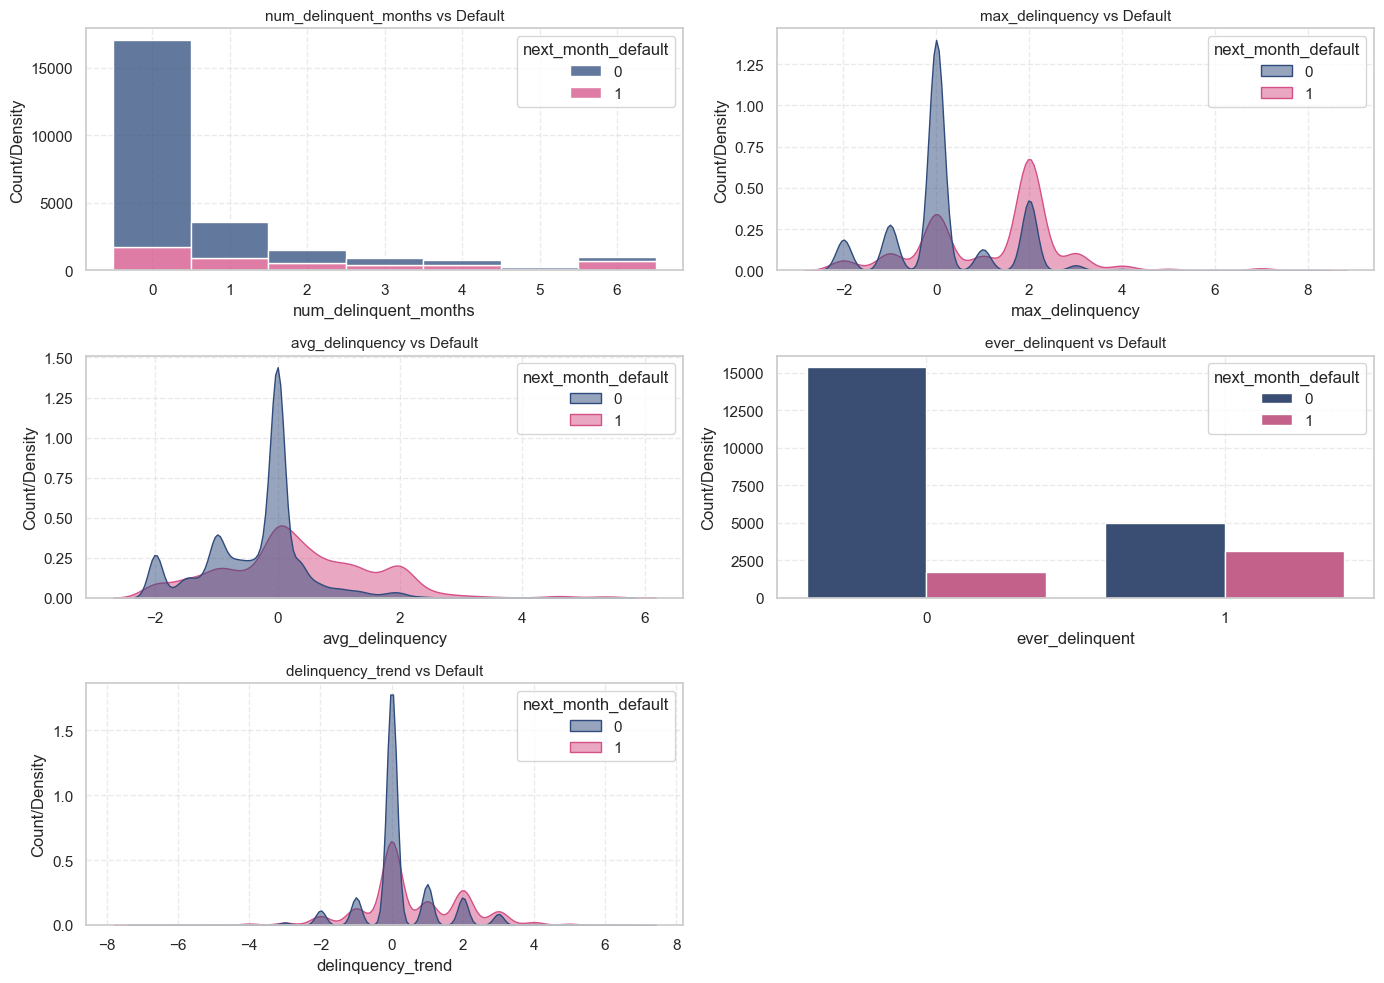

In [26]:
# Define features
cols = [
    'num_delinquent_months',
    'max_delinquency',
    'avg_delinquency',
    'ever_delinquent',
    'delinquency_trend',
]

# Custom blue palette
blue_palette=["#2f4b7c",  # Medium navy
              "#d45087",  # Pinkish-blue
             ]
# Set seaborn theme
sns.set_theme(style="whitegrid")

# Create subplot grid
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(cols):
    ax = axes[i]
    unique_vals = df[col].nunique()

    # Plot based on feature type
    if unique_vals <= 3:
        sns.countplot(data=df, x=col, hue=df['next_month_default'].astype(str), ax=ax, palette=blue_palette, edgecolor=None)
    elif unique_vals < 10 and df[col].dtype in ['int64', 'int32']:
        sns.histplot(data=df, x=col, hue=df['next_month_default'].astype(str), discrete=True, multiple='stack',
                     palette=blue_palette, ax=ax, edgecolor=None)
    else:
        sns.kdeplot(data=df, x=col, hue=df['next_month_default'].astype(str), fill=True,
                    common_norm=False, alpha=0.5, ax=ax, palette=blue_palette)


    ax.set_title(f'{col} vs Default', fontsize=11)
    ax.set_xlabel(col)
    ax.set_ylabel('Count/Density')
    ax.grid(True, linestyle='--', alpha=0.4)

# Remove unused subplot slot
for j in range(len(cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


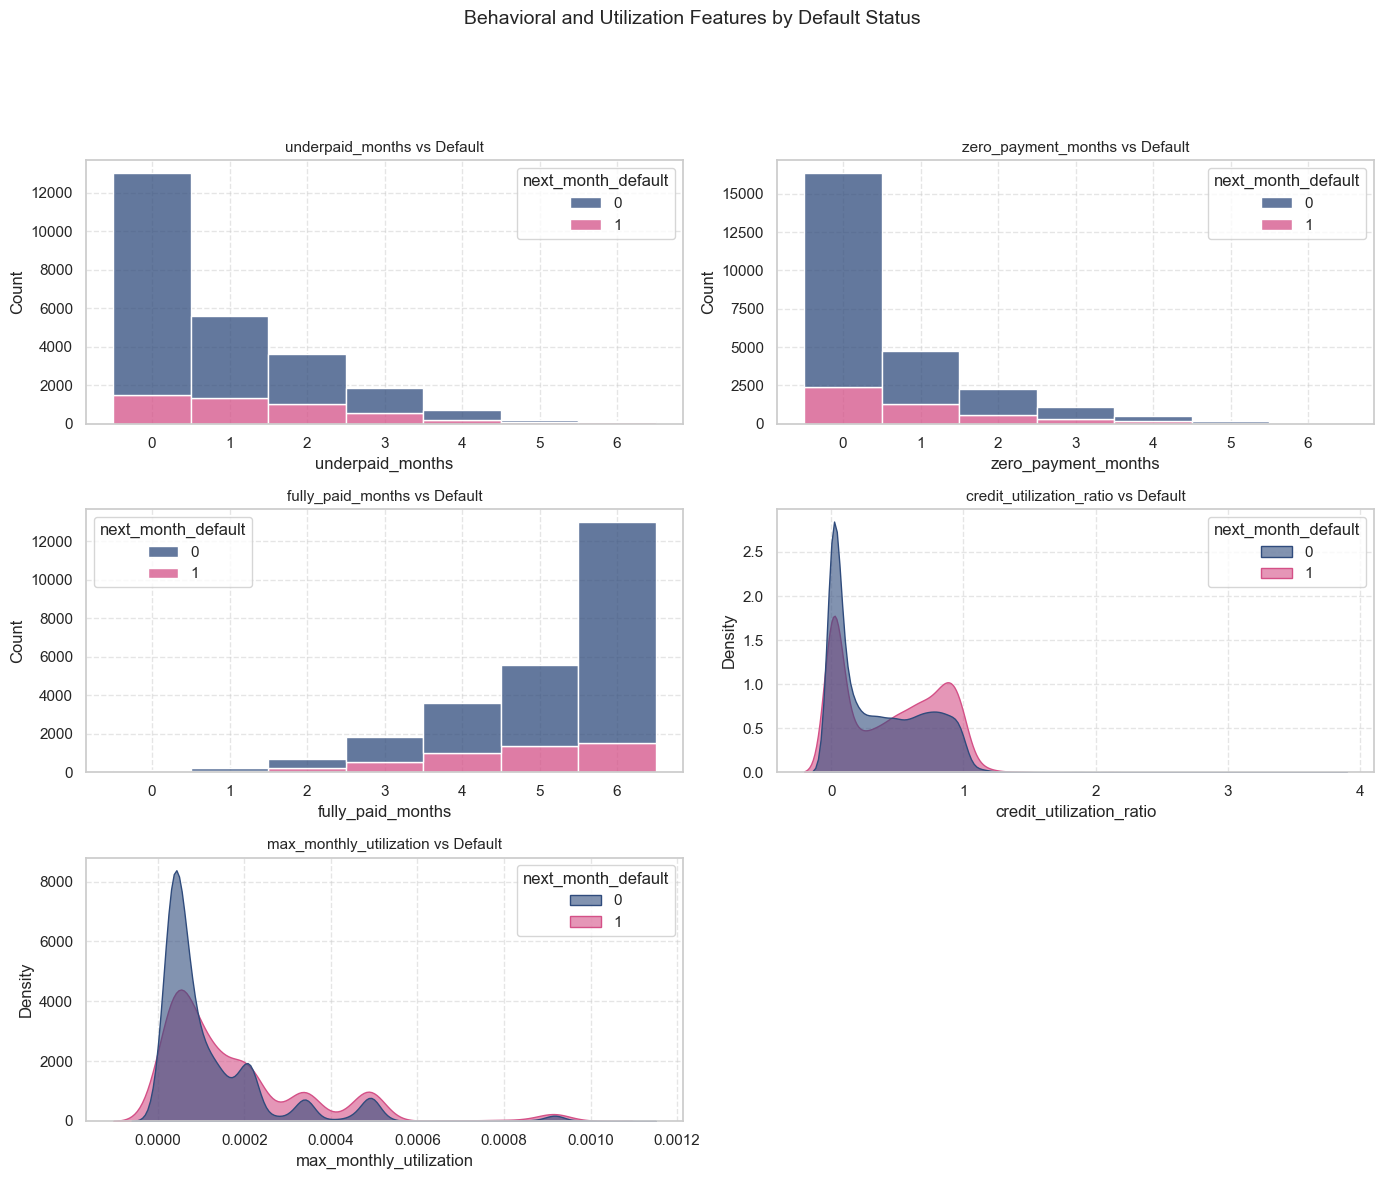

In [27]:
# Define visual theme
sns.set_theme(style="whitegrid")

# Custom green palette: lighter for class 1, darker for class 0
blue_palette = ["#2f4b7c",  # Medium navy
                 "#d45087",  # Pinkish-blue
               ]

# Features to plot
cols = [
    'underpaid_months',
    'zero_payment_months',
    'fully_paid_months',
    'credit_utilization_ratio',
    'max_monthly_utilization'
]

# Set up subplot grid (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(14, 11))
axes = axes.flatten()

for i, col in enumerate(cols):
    ax = axes[i]
    unique_vals = df[col].nunique()

    # Discrete features
    if unique_vals <= 7 and df[col].dtype in ['int64', 'int32']:
        sns.histplot(
            data=df, x=col, hue=df['next_month_default'].astype(str),
            multiple='stack', discrete=True, ax=ax,
            palette=blue_palette, edgecolor=None
        )
        ax.set_ylabel('Count')
    else:
        # Continuous features
        sns.kdeplot(
            data=df, x=col, hue=df['next_month_default'].astype(str),
            fill=True, common_norm=False, alpha=0.6, ax=ax,
            palette=blue_palette
        )
        ax.set_ylabel('Density')

    ax.set_title(f'{col} vs Default', fontsize=11)
    ax.set_xlabel(col)
    ax.grid(True, linestyle='--', alpha=0.5)

# Delete unused subplot
for j in range(len(cols), len(axes)):
    fig.delaxes(axes[j])

# Optional figure-wide title
fig.suptitle("Behavioral and Utilization Features by Default Status", fontsize=14, y=1.07)

plt.tight_layout()
plt.show()


**num_delinquent_months vs next_month_default**:

Insight: Majority of customers have 0 delinquent months. However, among those who do default, a higher proportion have 1 or more delinquent months.
Interpretation: Increasing count of delinquent months correlates with a higher risk of default.

**max_delinquency vs next_month_default**

Insight: Defaulters tend to have higher max_delinquency values, whereas non-defaulters are clustered around 0.
Interpretation: Higher maximum delinquency in the past indicates stronger default signals.

**avg_delinquency vs next_month_default**

Insight: A similar pattern is seen with avg_delinquency. Defaulters have a wider spread and more skewed distribution to the right.
Interpretation: Average delinquency over months is a useful continuous predictor—higher averages associate with greater default risk.

**ever_delinquent vs next_month_default**

Insight: A clear difference—majority of those who never were delinquent (0) didn’t default, while a higher proportion of delinquents (1) did.
Interpretation: A binary history of any delinquency is a strong risk indicator for future default.

**delinquency_trend vs next_month_default**

Insight: Defaulters exhibit a wider and slightly right-skewed distribution. While both defaulted and non-defaulted distributions peak near 0, the defaulter curve is more dispersed.
Interpretation: A rising delinquency trend might be an early warning sign, though some overlap exists.

**underpaid_months vs next_month_default**

Insight: Defaulters are more likely to have had 1–3 underpaid months than non-defaulters.
Interpretation: Partial payment history correlates positively with risk of default.

**zero_payment_months vs next_month_default**

Insight: Similar to underpaid months, a higher count of zero-payment months corresponds to more defaulters.
Interpretation: Zero payments in previous months is a red flag for future default.

**fully_paid_months vs next_month_default**

Insight: Those with consistently high full payments (5–6 months) are rarely defaulters. Those with fewer full payment months show a higher rate of default.
Interpretation: Consistency in full payments is protective against default.

**credit_utilization_ratio vs next_month_default**

Insight: Most users cluster around low utilization, but defaulters have a longer tail towards high utilization.
Interpretation: Higher credit utilization ratios are more common among defaulters and could be predictive.

**max_monthly_utilization vs next_month_default**

Insight: Similarly, while most users stay within a low max utilization range, defaulters again stretch more toward higher values.
Interpretation: Spikes in monthly utilization—even if rare—can be a risk flag.

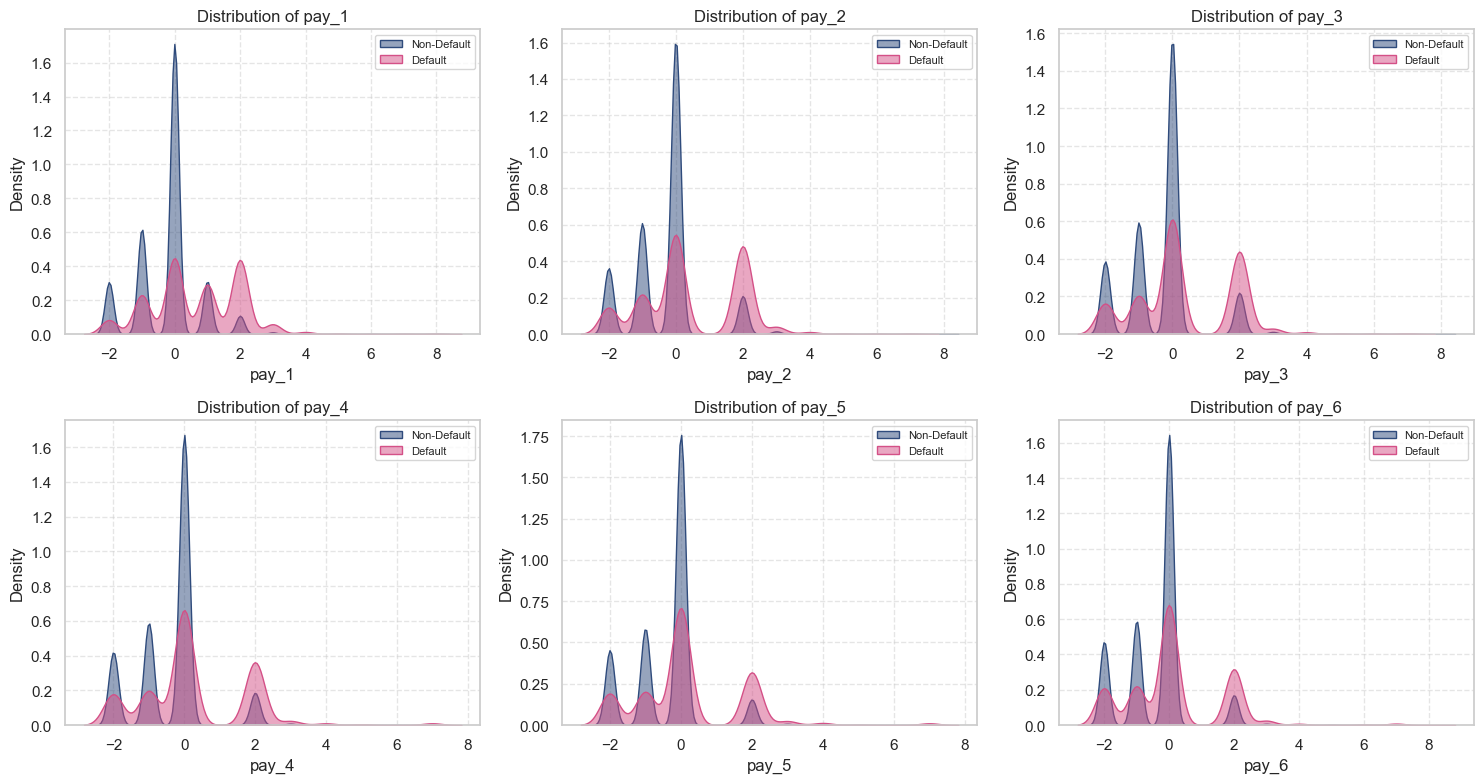

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn theme
sns.set_theme(style="whitegrid")

# Green color palette for Non-Default and Default
# lighter = default, darker = non- default
blue_palette = ["#2f4b7c",  # Medium navy
    "#d45087",  # Pinkish-blue 
]
# List of payment features
pay_cols = ['pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

# Set up subplots (3x2 grid)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

# Plot KDEs
for i, col in enumerate(pay_cols):
    ax = axes[i]
    sns.kdeplot(
        data=df[df['next_month_default'] == 0],
        x=col,
        fill=True,
        ax=ax,
        color=blue_palette[0],
        alpha=0.5,
        label='Non-Default'
    )
    sns.kdeplot(
        data=df[df['next_month_default'] == 1],
        x=col,
        fill=True,
        ax=ax,
        color=blue_palette[1],
        alpha=0.5,
        label='Default'
    )
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.5)

# Adjust layout
plt.tight_layout()
plt.show()


In [29]:
df['num_delinquent_months'].value_counts()

num_delinquent_months
0    17045
1     3571
2     1531
6     1017
3      909
4      756
5      248
Name: count, dtype: int64

In [30]:
df['ever_delinquent'].value_counts()


ever_delinquent
0    17045
1     8032
Name: count, dtype: int64

In [31]:
bill_cols = [f'Bill_amt{i}' for i in range(1, 7)]
df[bill_cols] = df[bill_cols].apply(lambda x: np.log1p(x))

In [32]:
X=df.drop('next_month_default',axis=1)
y = df['next_month_default']

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (20061, 44)
X_test shape: (5016, 44)
y_train shape: (20061,)
y_test shape: (5016,)


In [34]:
import numpy as np
from imblearn.over_sampling import SMOTENC

categorical_features = ['sex', 'education', 'marriage', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
categorical_indices = [X.columns.get_loc(col) for col in categorical_features]
from imblearn.over_sampling import SMOTENC

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_train_resampled_np, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

X_train_resampled = pd.DataFrame(X_train_resampled_np, columns=X_train.columns)


In [35]:
numeric_cols = [col for col in X.columns if col not in categorical_features]
scaler = StandardScaler()
X_train_resampled[numeric_cols] = scaler.fit_transform(X_train_resampled[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [36]:
# LOGISTIC REGRESSION
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train_resampled,y_train_resampled)

# Predict on the test set
y_pred = logistic_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Logistic Regression Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Logistic Regression Model Performance:
Accuracy: 0.8176

Confusion Matrix:
[[3680  381]
 [ 534  421]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      4061
           1       0.52      0.44      0.48       955

    accuracy                           0.82      5016
   macro avg       0.70      0.67      0.68      5016
weighted avg       0.81      0.82      0.81      5016



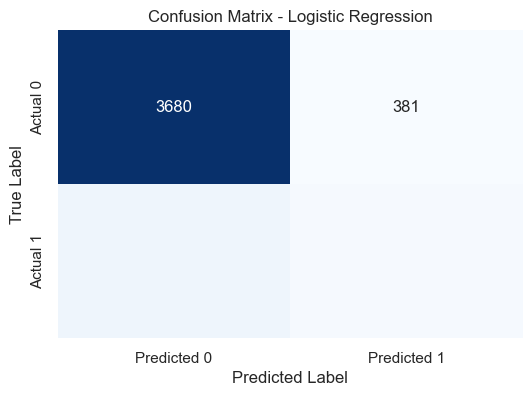

In [37]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

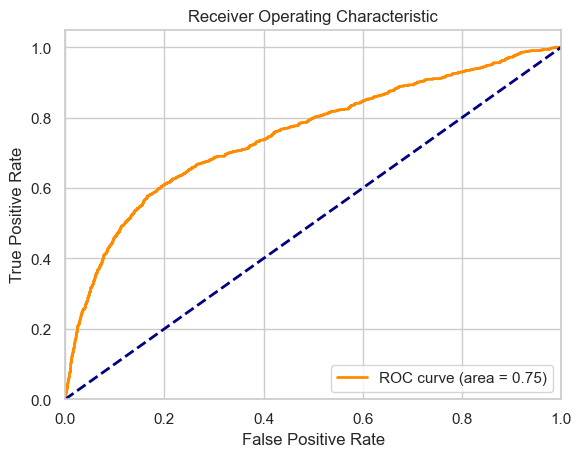

Optimal Threshold (based on Youden's J statistic): 0.3865


In [38]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class (class 1)
y_prob = logistic_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
j_scores = tpr - fpr
optimal_threshold_index = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_threshold_index]

print(f"Optimal Threshold (based on Youden's J statistic): {optimal_threshold:.4f}")


Logistic Regression Model Performance (using Optimal Threshold = 0.3865):
Accuracy: 0.7851

Confusion Matrix:
[[3386  675]
 [ 403  552]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      4061
           1       0.45      0.58      0.51       955

    accuracy                           0.79      5016
   macro avg       0.67      0.71      0.68      5016
weighted avg       0.81      0.79      0.79      5016



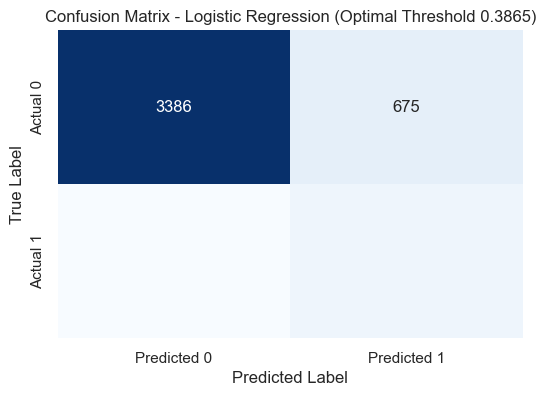

In [39]:
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)

# Evaluate performance with the optimal threshold
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)
conf_matrix_optimal = confusion_matrix(y_test, y_pred_optimal)
class_report_optimal = classification_report(y_test, y_pred_optimal)

print(f"\nLogistic Regression Model Performance (using Optimal Threshold = {optimal_threshold:.4f}):")
print(f"Accuracy: {accuracy_optimal:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_optimal)
print("\nClassification Report:")
print(class_report_optimal)

# Optional: Visualize the confusion matrix with optimal threshold
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_optimal, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title(f'Confusion Matrix - Logistic Regression (Optimal Threshold {optimal_threshold:.4f})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Max F2 Score: 0.5784
Threshold at Max F2 Score: 0.2626
Accuracy at Max F2 Score Threshold: 0.6041

Classification Report at Max F2 Threshold:
              precision    recall  f1-score   support

           0       0.91      0.57      0.70      4061
           1       0.29      0.76      0.42       955

    accuracy                           0.60      5016
   macro avg       0.60      0.67      0.56      5016
weighted avg       0.79      0.60      0.65      5016



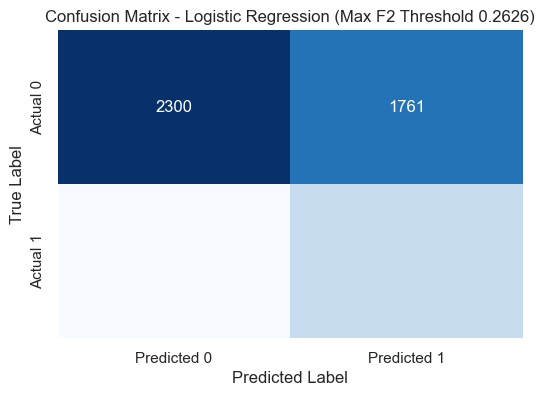

In [40]:
y_prob = logistic_model.predict_proba(X_test)[:, 1]
thresholds = np.linspace(0, 1, 100)

best_f2 = 0
best_threshold = 0
accuracy_at_best_f2 = 0
for threshold in thresholds:
    y_pred_threshold = (y_prob >= threshold).astype(int)
    f2 = fbeta_score(y_test, y_pred_threshold, beta=2.0)
    if f2 > best_f2:
        best_f2 = f2
        best_threshold = threshold
        accuracy_at_best_f2 = accuracy_score(y_test, y_pred_threshold)

print(f"Max F2 Score: {best_f2:.4f}")
print(f"Threshold at Max F2 Score: {best_threshold:.4f}")
print(f"Accuracy at Max F2 Score Threshold: {accuracy_at_best_f2:.4f}")

y_pred_best_f2 = (y_prob >= best_threshold).astype(int)
print("\nClassification Report at Max F2 Threshold:")
print(classification_report(y_test, y_pred_best_f2))
conf_matrix_best_f2 = confusion_matrix(y_test, y_pred_best_f2)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_best_f2, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title(f'Confusion Matrix - Logistic Regression (Max F2 Threshold {best_threshold:.4f})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


XGBoost Model Performance (Default Threshold):
Accuracy: 0.8315

Confusion Matrix:
[[3795  266]
 [ 579  376]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4061
           1       0.59      0.39      0.47       955

    accuracy                           0.83      5016
   macro avg       0.73      0.66      0.69      5016
weighted avg       0.81      0.83      0.82      5016


AUC: 0.7676


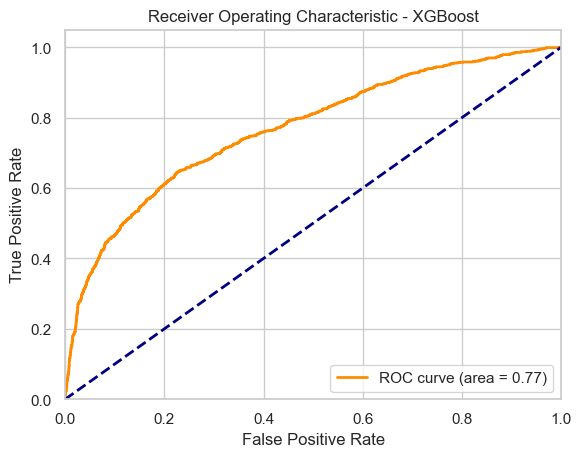

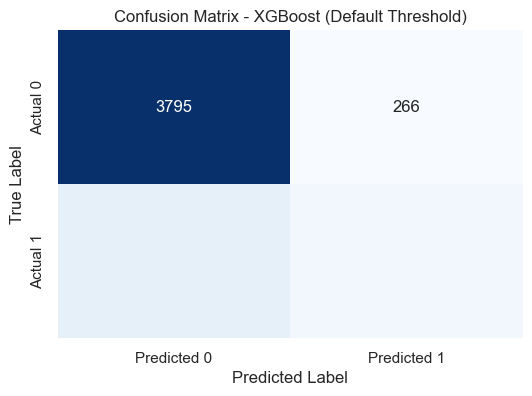

In [41]:
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb_model.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
class_report_xgb = classification_report(y_test, y_pred_xgb)

print("XGBoost Model Performance (Default Threshold):")
print(f"Accuracy: {accuracy_xgb:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_xgb)
print("\nClassification Report:")
print(class_report_xgb)

y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

print(f"\nAUC: {roc_auc_xgb:.4f}")
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - XGBoost')
plt.legend(loc="lower right")
plt.show()
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix - XGBoost (Default Threshold)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


XGBoost Optimal Threshold to Maximize F2-score: 0.1515
Maximum F2-score achieved: 0.5897

XGBoost Model Performance with F2-Optimized Threshold (0.1515):
Accuracy: 0.6541
F2 Score: 0.5897

Confusion Matrix:
[[2571 1490]
 [ 245  710]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.63      0.75      4061
           1       0.32      0.74      0.45       955

    accuracy                           0.65      5016
   macro avg       0.62      0.69      0.60      5016
weighted avg       0.80      0.65      0.69      5016



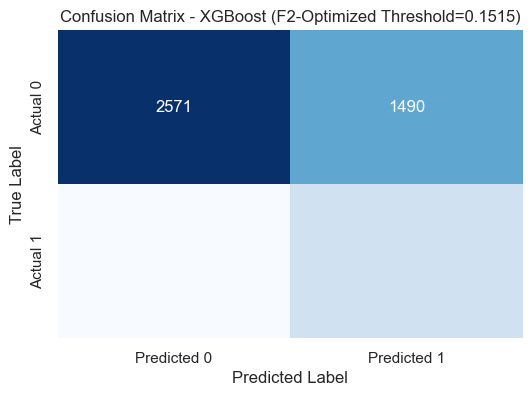

In [42]:
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

best_f2 = 0
optimal_threshold_f2 = 0
thresholds_to_check = np.linspace(0, 1, 100)

for threshold in thresholds_to_check:
  y_pred_at_threshold = (y_pred_proba_xgb >= threshold).astype(int)
  f2_at_threshold = fbeta_score(y_test, y_pred_at_threshold, beta=2)

  if f2_at_threshold > best_f2:
    best_f2 = f2_at_threshold
    optimal_threshold_f2 = threshold

print(f"XGBoost Optimal Threshold to Maximize F2-score: {optimal_threshold_f2:.4f}")
print(f"Maximum F2-score achieved: {best_f2:.4f}")

y_pred_f2_optimized_xgb = (y_pred_proba_xgb >= optimal_threshold_f2).astype(int)
accuracy_f2_optimized_xgb = accuracy_score(y_test, y_pred_f2_optimized_xgb)
conf_matrix_f2_optimized_xgb = confusion_matrix(y_test, y_pred_f2_optimized_xgb)
class_report_f2_optimized_xgb = classification_report(y_test, y_pred_f2_optimized_xgb)
f2_score_optimized_xgb = fbeta_score(y_test, y_pred_f2_optimized_xgb, beta=2)

print(f"\nXGBoost Model Performance with F2-Optimized Threshold ({optimal_threshold_f2:.4f}):")
print(f"Accuracy: {accuracy_f2_optimized_xgb:.4f}")
print(f"F2 Score: {f2_score_optimized_xgb:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_f2_optimized_xgb)
print("\nClassification Report:")
print(class_report_f2_optimized_xgb)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_f2_optimized_xgb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title(f'Confusion Matrix - XGBoost (F2-Optimized Threshold={optimal_threshold_f2:.4f})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Random Forest Model Performance:
Accuracy: 0.8299

Confusion Matrix:
[[3763  298]
 [ 555  400]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4061
           1       0.57      0.42      0.48       955

    accuracy                           0.83      5016
   macro avg       0.72      0.67      0.69      5016
weighted avg       0.81      0.83      0.82      5016

Random Forest AUC: 0.7751


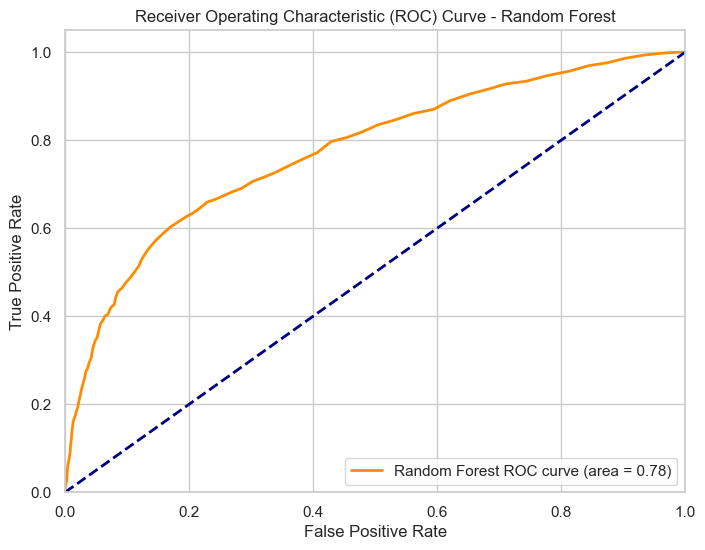

In [43]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

y_pred_rf = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)

print("Random Forest Model Performance:")
print(f"Accuracy: {accuracy_rf:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_rf)
print("\nClassification Report:")
print(class_report_rf)

y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)

roc_auc_rf = auc(fpr_rf, tpr_rf)

print(f"Random Forest AUC: {roc_auc_rf:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Random Forest ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

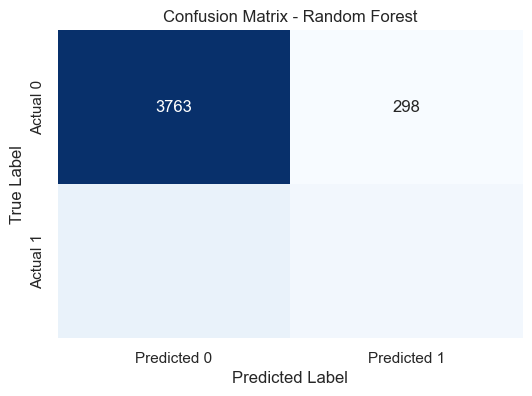

In [44]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, fbeta_score, precision_recall_curve # Import precision_recall_curve here

y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_prob_rf)
f2_scores_rf = [fbeta_score(y_test, (y_prob_rf >= t).astype(int), beta=2) for t in thresholds_rf]
optimal_threshold_index_f2_rf = np.argmax(f2_scores_rf)
optimal_threshold_f2_rf = thresholds_rf[optimal_threshold_index_f2_rf]

print(f"Random Forest Optimal Threshold (maximizing F2 Score): {optimal_threshold_f2_rf:.4f}")
y_pred_optimal_f2_rf = (y_prob_rf >= optimal_threshold_f2_rf).astype(int)
accuracy_optimal_f2_rf = accuracy_score(y_test, y_pred_optimal_f2_rf)
conf_matrix_optimal_f2_rf = confusion_matrix(y_test, y_pred_optimal_f2_rf)
class_report_optimal_f2_rf = classification_report(y_test, y_pred_optimal_f2_rf)
f2_score_optimal_f2_rf = fbeta_score(y_test, y_pred_optimal_f2_rf, beta=2)

print(f"\nRandom Forest Model Performance (using Optimal F2 Threshold = {optimal_threshold_f2_rf:.4f}):")
print(f"Accuracy: {accuracy_optimal_f2_rf:.4f}")
print(f"F2 Score: {f2_score_optimal_f2_rf:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_optimal_f2_rf)
print("\nClassification Report:")
print(class_report_optimal_f2_rf)

Random Forest Optimal Threshold (maximizing F2 Score): 0.2000

Random Forest Model Performance (using Optimal F2 Threshold = 0.2000):
Accuracy: 0.6142
F2 Score: 0.6019

Confusion Matrix:
[[2320 1741]
 [ 194  761]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.57      0.71      4061
           1       0.30      0.80      0.44       955

    accuracy                           0.61      5016
   macro avg       0.61      0.68      0.57      5016
weighted avg       0.81      0.61      0.66      5016



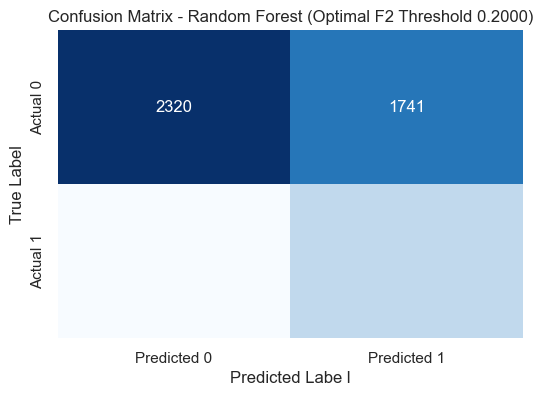

In [46]:
# Optional: Visualize the confusion matrix with optimal F2 threshold
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_optimal_f2_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title(f'Confusion Matrix - Random Forest (Optimal F2 Threshold {optimal_threshold_f2_rf:.4f})')
plt.xlabel('Predicted Labe l')
plt.ylabel('True Label')
plt.show()

In [47]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTENC
from tensorflow.keras.utils import to_categorical

# Load and split data
X = df.drop('next_month_default', axis=1)
y = df['next_month_default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Categorical features for SMOTENC
categorical_features = ['sex', 'education', 'marriage', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
categorical_indices = [X_train.columns.get_loc(col) for col in categorical_features]

# SMOTENC
X_train_np = X_train.values
y_train_np = y_train.values
smote = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_np, y_train_np)

# Scaling numeric features
numeric_cols = X_train.columns.difference(categorical_features)
numeric_indices = [X_train.columns.get_loc(col) for col in numeric_cols]

scaler = StandardScaler()
X_train_resampled[:, numeric_indices] = scaler.fit_transform(X_train_resampled[:, numeric_indices])
X_test_np = X_test.values
X_test_np[:, numeric_indices] = scaler.transform(X_test_np[:, numeric_indices])
X_test_scaled = X_test_np


In [48]:
# Define sequential features for LSTM
sequential_features = [f'Bill_amt{i}' for i in range(1, 7)] + \
                      [f'pay_amt{i}' for i in range(1, 7)] + \
                      ['pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

# Remaining = non-sequential
non_sequential_features = [col for col in X.columns if col not in sequential_features]

# Get column indices
seq_idx = [X.columns.get_loc(col) for col in sequential_features]
non_seq_idx = [X.columns.get_loc(col) for col in non_sequential_features]

# Slice and reshape
X_train_seq = X_train_resampled[:, seq_idx].reshape(-1, 1, len(seq_idx))
X_train_non_seq = X_train_resampled[:, non_seq_idx]

X_test_seq = X_test_scaled[:, seq_idx].reshape(-1, 1, len(seq_idx))
X_test_non_seq = X_test_scaled[:, non_seq_idx]

# One-hot encode y
y_train_cat = to_categorical(y_train_resampled)
y_test_cat = to_categorical(y_test.values)

In [49]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# LSTM input
seq_input = Input(shape=(1, len(seq_idx)), name='seq_input')
lstm_out = LSTM(64, return_sequences=False)(seq_input)
lstm_out = Dropout(0.3)(lstm_out)

# Dense input
non_seq_input = Input(shape=(len(non_seq_idx),), name='non_seq_input')
non_seq_out = Dense(32, activation='relu')(non_seq_input)
non_seq_out = Dropout(0.3)(non_seq_out)

# Merge
merged = concatenate([lstm_out, non_seq_out])
x = Dense(32, activation='relu')(merged)
x = Dropout(0.3)(x)
output = Dense(2, activation='softmax')(x)

# Model
model = Model(inputs=[seq_input, non_seq_input], outputs=output)
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    [X_train_seq, X_train_non_seq],
    y_train_cat,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
407/407 [==============================] - 4s 4ms/step - loss: 0.5732 - accuracy: 0.7145 - val_loss: 0.7197 - val_accuracy: 0.5732
Epoch 2/50
407/407 [==============================] - 1s 3ms/step - loss: 0.5312 - accuracy: 0.7493 - val_loss: 0.6666 - val_accuracy: 0.6446
Epoch 3/50
407/407 [==============================] - 1s 3ms/step - loss: 0.5077 - accuracy: 0.7662 - val_loss: 0.6589 - val_accuracy: 0.6780
Epoch 4/50
407/407 [==============================] - 1s 3ms/step - loss: 0.4919 - accuracy: 0.7758 - val_loss: 0.5864 - val_accuracy: 0.7209
Epoch 5/50
407/407 [==============================] - 1s 3ms/step - loss: 0.4812 - accuracy: 0.7828 - val_loss: 0.5360 - val_accuracy: 0.7197
Epoch 6/50
407/407 [==============================] - 1s 3ms/step - loss: 0.4709 - accuracy: 0.7882 - val_loss: 0.4998 - val_accuracy: 0.7428
Epoch 7/50
407/407 [==============================] - 1s 3ms/step - loss: 0.4628 - accuracy: 0.7932 - val_loss: 0.4829 - val_accuracy: 0.7470
Epoch 

157/157 [==============================] - 1s 2ms/step
Accuracy: 0.8311
Precision: 0.5885
Recall: 0.3759
F2 Score: 0.4052


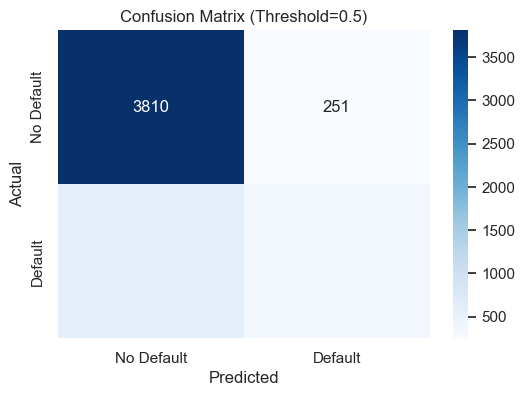

In [50]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, fbeta_score, roc_curve, auc, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Predict probabilities
y_pred_prob = model.predict([X_test_seq, X_test_non_seq])[:, 1]
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Metrics
f2 = fbeta_score(y_test, y_pred_class, beta=2)
acc = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F2 Score: {f2:.4f}")

# Confusion Matrix
conf = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(6,4))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Threshold=0.5)")
plt.show()


157/157 [==============================] - 0s 2ms/step
Neural Network AUC: 0.7744


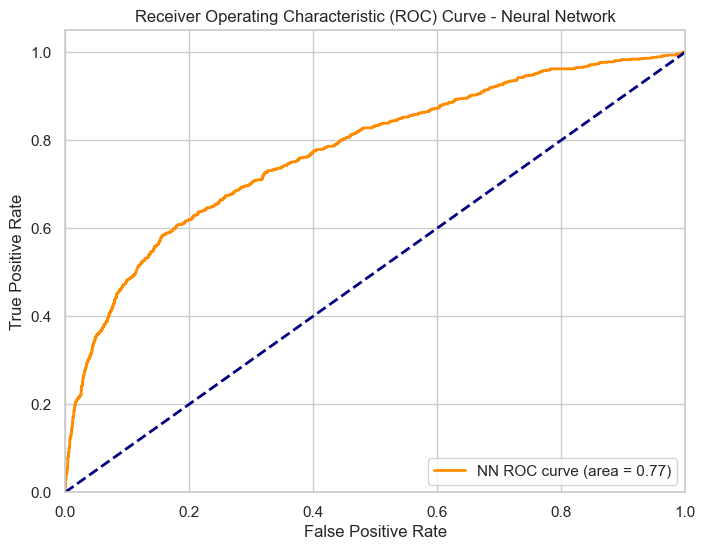

In [51]:
import matplotlib.pyplot as plt
# Get predicted probabilities for the positive class (class 1) from the NN model
y_pred_prob_nn = model.predict([X_test_seq, X_test_non_seq])[:, 1]

# Calculate ROC curve
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_prob_nn)

# Calculate AUC
roc_auc_nn = auc(fpr_nn, tpr_nn)

print(f"Neural Network AUC: {roc_auc_nn:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_nn, tpr_nn, color='darkorange', lw=2, label=f'NN ROC curve (area = {roc_auc_nn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Neural Network')
plt.legend(loc="lower right")
plt.show()



157/157 [==============================] - 0s 1ms/step
Neural Network Optimal Threshold (maximizing F2 Score): 0.1745
Maximum F2 Score achieved: 0.6024

Neural Network Model Performance (using Optimal F2 Threshold = 0.1745):
Accuracy: 0.5789

Confusion Matrix:
[[2114 1947]
 [ 165  790]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.52      0.67      4061
           1       0.29      0.83      0.43       955

    accuracy                           0.58      5016
   macro avg       0.61      0.67      0.55      5016
weighted avg       0.81      0.58      0.62      5016



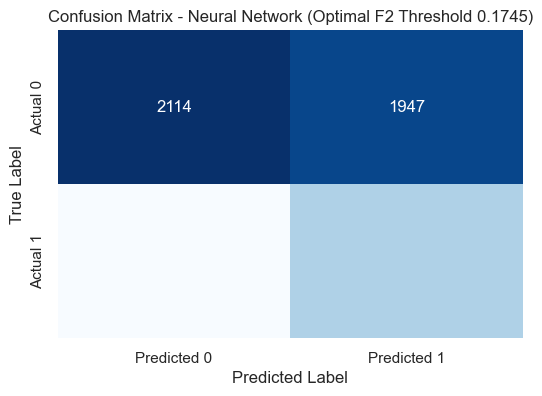

In [52]:
from sklearn.metrics import fbeta_score, confusion_matrix, classification_report, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get predicted probabilities for the positive class (class 1) from the NN model
y_pred_prob_nn = model.predict([X_test_seq, X_test_non_seq])[:, 1]

# Calculate precision and recall for various thresholds
precision_nn, recall_nn, thresholds_nn = precision_recall_curve(y_test, y_pred_prob_nn)

# Calculate F2 score for each threshold
# Note: The length of thresholds_nn is one less than precision_nn and recall_nn
f2_scores_nn = [fbeta_score(y_test, (y_pred_prob_nn >= t).astype(int), beta=2) for t in thresholds_nn]

# Find the threshold that maximizes the F2 score
optimal_threshold_index_f2_nn = np.argmax(f2_scores_nn)
optimal_threshold_f2_nn = thresholds_nn[optimal_threshold_index_f2_nn]

# Get the maximum F2 score
max_f2_nn = f2_scores_nn[optimal_threshold_index_f2_nn]

print(f"Neural Network Optimal Threshold (maximizing F2 Score): {optimal_threshold_f2_nn:.4f}")
print(f"Maximum F2 Score achieved: {max_f2_nn:.4f}")

# Predict using the optimal threshold that maximizes F2 score
y_pred_optimal_f2_nn = (y_pred_prob_nn >= optimal_threshold_f2_nn).astype(int)

# Evaluate performance with the optimal F2 threshold
accuracy_optimal_f2_nn = accuracy_score(y_test, y_pred_optimal_f2_nn)
conf_matrix_optimal_f2_nn = confusion_matrix(y_test, y_pred_optimal_f2_nn)
class_report_optimal_f2_nn = classification_report(y_test, y_pred_optimal_f2_nn)

print(f"\nNeural Network Model Performance (using Optimal F2 Threshold = {optimal_threshold_f2_nn:.4f}):")
print(f"Accuracy: {accuracy_optimal_f2_nn:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_optimal_f2_nn)
print("\nClassification Report:")
print(class_report_optimal_f2_nn)

# Visualize the confusion matrix with optimal F2 threshold
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_optimal_f2_nn, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title(f'Confusion Matrix - Neural Network (Optimal F2 Threshold {optimal_threshold_f2_nn:.4f})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

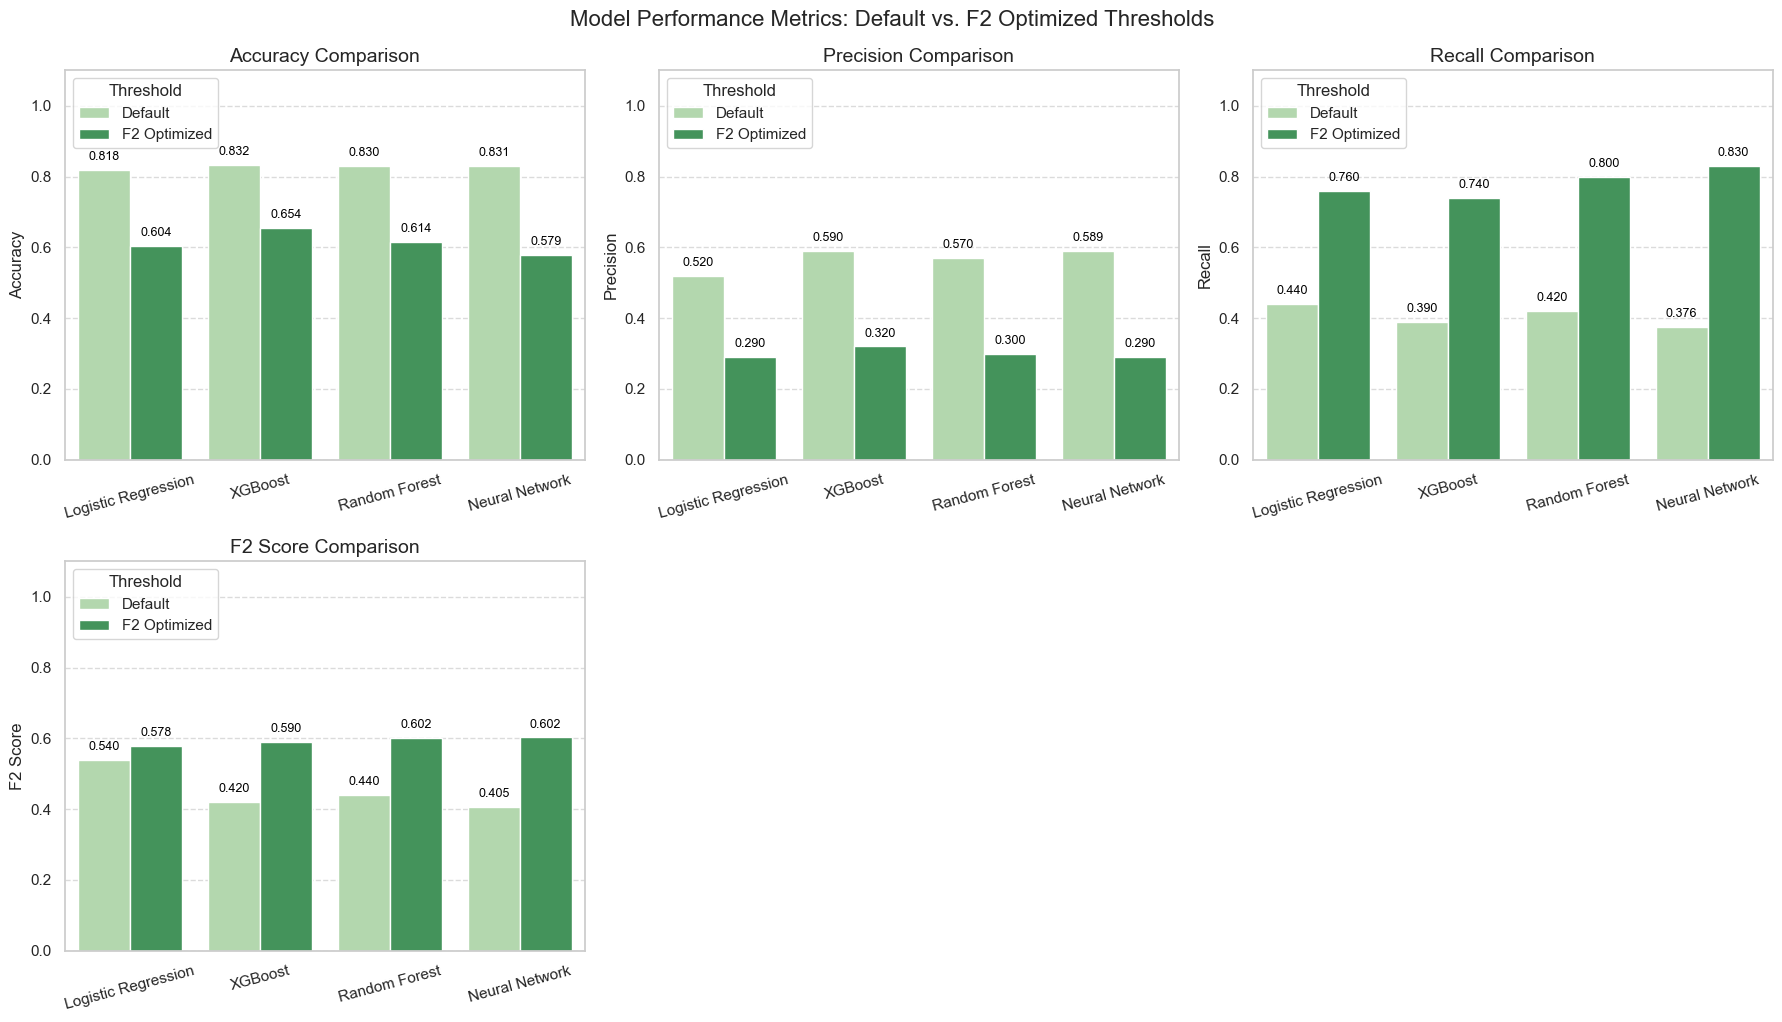

In [65]:
# Define performance metrics from user data
metrics_default = {
    'Logistic Regression': {
        'Accuracy': 0.8176,
        'Precision': 0.52,
        'Recall': 0.44,
        'F2 Score': 0.54
    },
    'XGBoost': {
        'Accuracy': 0.8315,
        'Precision': 0.59,
        'Recall': 0.39,
        'F2 Score': 0.42
    },
    'Random Forest': {
        'Accuracy': 0.8299,
        'Precision': 0.57,
        'Recall': 0.42,
        'F2 Score': 0.44
    },
    'Neural Network': {
        'Accuracy': 0.8311,
        'Precision': 0.5885,
        'Recall': 0.3759,
        'F2 Score': 0.4052
    }
}

metrics_optimized = {
    'Logistic Regression': {
        'Accuracy': 0.6041,
        'Precision': 0.29,
        'Recall': 0.76,
        'F2 Score': 0.5784,
    },
    'XGBoost': {
        'Accuracy': 0.6541,
        'Precision': 0.32,
        'Recall': 0.74,
        'F2 Score': 0.5897
    },
    'Random Forest': {
        'Accuracy': 0.6142,
        'Precision': 0.30,
        'Recall': 0.80,
        'F2 Score': 0.6019
    },
    'Neural Network': {
        'Accuracy': 0.5789,
        'Precision': 0.29,
        'Recall': 0.83,
        'F2 Score': 0.6024
    }
}

# Convert dictionaries to tidy DataFrames
df_default = pd.DataFrame(metrics_default).T.stack().reset_index()
df_default.columns = ['Model', 'Metric', 'Value']
df_default['Threshold'] = 'Default'

df_optimized = pd.DataFrame(metrics_optimized).T.stack().reset_index()
df_optimized.columns = ['Model', 'Metric', 'Value']
df_optimized['Threshold'] = 'F2 Optimized'

# Combine for plotting
df_combined = pd.concat([df_default, df_optimized])

# Plotting
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F2 Score']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

greens_shades = sns.color_palette("Greens", n_colors=2)
palette = {'Default': green_shades[0], 'F2 Optimized': green_shades[1]}

for i, metric in enumerate(metrics_to_plot):
    if i >= len(axes):
        continue
    ax = axes[i]
    data = df_combined[df_combined['Metric'] == metric]
    sns.barplot(x='Model', y='Value', hue='Threshold', data=data, palette=palette, ax=ax)

    ax.set_title(f'{metric} Comparison', fontsize=14)
    ax.set_ylim(0, 1.1)
    ax.tick_params(axis='x', rotation=15)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylabel(metric)
    ax.set_xlabel('')

    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:
                ax.annotate(f'{height:.3f}',
                            (bar.get_x() + bar.get_width() / 2., height),
                            ha='center', va='bottom',
                            fontsize=9, color='black', xytext=(0, 5),
                            textcoords='offset points')

    ax.legend(title='Threshold', loc='upper left')

# Remove extra plot if present
if len(metrics_to_plot) < len(axes):
    for j in range(len(metrics_to_plot), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Model Performance Metrics: Default vs. F2 Optimized Thresholds', fontsize=16, y=1.02)
plt.show()



# Prediction

In [99]:
val = pd.read_csv('practice-datasets/validate_dataset_final.csv')
val.drop('Customer_ID', axis=1, inplace=True)
val.rename(columns={'pay_0': 'pay_1'}, inplace=True)
val.reset_index(drop=True, inplace=True)
X_val= val.copy()

In [100]:
engineer_credit_features(X_val)

,marriage,sex,education,LIMIT_BAL,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,Bill_amt1,Bill_amt2,Bill_amt3,Bill_amt4,Bill_amt5,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,credit_utilization_ratio,max_monthly_utilization,num_delinquent_months,max_delinquency,avg_delinquency,ever_delinquent,delinquency_trend,total_bill_amt,total_pay_amt,avg_pay_amt,underpaid_months,overpaid_months,bill_amt_std,pay_amt_std,bill_amt_range,pay_amt_range,zero_spending_months,zero_payment_months,fully_paid_months
0,1,1,2,220000,32,0,0,0,0,0,0,28853.10,29144.77,27172.12,22066.47,17831.13,15670.47,2000.03,3999.90,1419.80,1999.97,3000.21,30788.71,23456.33,0.31,0.106620,0.132476,0,0,0.000000,0,0,140738.06,43208.62,7201.436667,5,1,5822.109123,11591.348629,13474.30,29368.91,0,0,1
1,2,0,1,350000,35,-1,-1,-1,0,0,0,4438.78,33718.18,14284.09,16425.68,10832.78,2261.45,33891.01,16267.19,4026.80,234.10,1565.11,26346.39,13660.33,1.00,0.039030,0.096338,0,0,-0.500000,0,-1,81960.96,82330.60,13721.766667,4,2,11254.510849,14116.320363,31456.73,33656.91,0,0,2
2,2,1,1,310000,39,0,0,0,0,0,0,300500.53,265766.60,245457.90,249435.52,240520.57,246524.45,11026.94,10499.83,14000.32,10000.12,10000.16,10000.21,258034.17,0.04,0.832368,0.969357,0,0,0.000000,0,0,1548205.57,65527.58,10921.263333,6,0,22514.357169,1562.986833,59979.96,4000.20,0,0,0
3,1,0,2,20000,47,0,0,0,2,2,2,10628.45,11650.67,14252.14,13678.06,15040.17,14749.97,1200.00,2799.83,0.14,1499.93,0.02,1000.26,13333.33,0.08,0.666666,0.752008,3,2,1.000000,1,-2,79999.46,6500.18,1083.363333,6,0,1790.583297,1047.597389,4411.72,2799.81,0,0,0
4,2,1,2,500000,30,0,0,0,0,0,0,98617.77,73464.07,84740.39,72510.59,69054.15,64841.30,25463.94,43095.31,7521.96,9065.17,8841.07,12000.21,77204.50,0.23,0.154409,0.197236,0,0,0.000000,0,0,463228.27,105987.66,17664.610000,6,0,12414.655025,14101.872597,33776.47,35573.35,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5011,1,0,2,240000,51,0,0,0,0,0,0,98588.36,100544.66,102650.93,104748.89,106832.47,109060.11,3591.87,3718.80,3797.93,3820.66,3949.01,3976.22,103737.83,0.04,0.432241,0.454417,0,0,0.000000,0,0,622425.42,22854.49,3809.081667,6,0,3919.704851,143.600324,10471.75,384.35,0,0,0
5012,1,1,3,60000,33,0,0,0,0,0,0,57560.27,57765.42,49351.45,28547.74,29062.53,28862.41,2100.23,3000.32,1499.86,1499.82,1099.82,1100.18,41858.83,0.04,0.697647,0.962757,0,0,0.000000,0,0,251149.82,10300.23,1716.705000,6,0,14598.160979,727.938175,29217.68,1900.50,0,0,0
5013,1,0,1,290000,36,1,-2,-1,-1,0,0,0.00,0.00,567.27,16166.71,16725.60,17427.88,0.00,568.10,16165.93,1000.03,1000.05,1000.15,8481.17,0.39,0.029245,0.060096,1,1,-0.500000,1,1,50887.46,19734.26,3289.043333,3,2,9094.746541,6320.659050,17427.88,16165.93,2,1,3
5014,1,1,2,120000,28,0,0,0,0,0,0,103675.25,96833.58,78920.51,74309.81,75710.06,77502.18,3283.48,2999.75,5000.26,3000.13,2999.95,4000.04,84492.00,0.04,0.704100,0.863960,0,0,0.000000,0,0,506951.39,21283.61,3547.268333,6,0,12498.081654,810.489394,29365.44,2000.51,0,0,0


In [101]:
sequential_features = [f'Bill_amt{i}' for i in range(1, 7)] + \
                      [f'pay_amt{i}' for i in range(1, 7)] + \
                      ['pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']


In [102]:
non_sequential_features = [col for col in X_val.columns if col not in sequential_features]

# Column indices
seq_idx_val = [X_val.columns.get_loc(col) for col in sequential_features]
non_seq_idx_val = [X_val.columns.get_loc(col) for col in non_sequential_features]

In [103]:
X_val_np = X_val.values
X_val_np[:, numeric_indices] = scaler.transform(X_val_np[:, numeric_indices]) # Use the scaler fitted on training data

X_val_seq = X_val_np[:, seq_idx_val].reshape(-1, 1, len(seq_idx_val))
X_val_non_seq = X_val_np[:, non_seq_idx_val]

# Get predictions with the optimal threshold from the Neural Network model
y_pred_prob_val = model.predict([X_val_seq, X_val_non_seq])[:, 1]
y_pred_optimal_f2_val = (y_pred_prob_val >= optimal_threshold_f2_nn).astype(int)

print(f"\nPredictions on Validation Data using Neural Network with Optimal F2 Threshold ({optimal_threshold_f2_nn:.4f}):")
print(y_pred_optimal_f2_val[:100]) # Print first 10 predictions as an example
print(f"\nTotal number of predictions: {len(y_pred_optimal_f2_val)}")


157/157 [==============================] - 1s 3ms/step

Predictions on Validation Data using Neural Network with Optimal F2 Threshold (0.1745):
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Total number of predictions: 5016


In [104]:
import numpy as np
counts = np.bincount(y_pred_optimal_f2_val)
if len(counts) < 2:
    counts = np.pad(counts, (0, 2 - len(counts)), 'constant')

print(f"Count of 0s in y_pred_optimal_f2_val: {counts[0]}")
print(f"Count of 1s in y_pred_optimal_f2_val: {counts[1]}")

Count of 0s in y_pred_optimal_f2_val: 4862
Count of 1s in y_pred_optimal_f2_val: 154


In [105]:
submission_df = pd.DataFrame({'Customer_ID': range(1, len(y_pred_optimal_f2_val) + 1),
                              'next_month_default': y_pred_optimal_f2_val})
submission_df.to_csv('submission_23118001.csv', index=False)

print("Submission file 'submission_23118001.csv' created successfully.")

Submission file 'submission_23118001.csv' created successfully.
